In [4]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [8]:
import random
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

In [10]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [45]:
X_train = pd.read_pickle('saved_model/rmse_839/X_train.pkl')
X_test = pd.read_pickle('saved_model/rmse_839/X_test.pkl')
ratings = pd.read_pickle("./Data/final_dataset_pre_split.pkl")

In [7]:
model = keras.models.load_model('saved_model/rmse_839/model.h5')

In [46]:
test_user = random.choice(ratings.user.unique())
ratings[ratings.user==test_user]

,movie_id,rating_score,user_id,user,movie
6605,1078,3,97031706,62845,1032
22042,1097,2,97031706,62845,1050
71770,1189,2,97031706,62845,1133
97815,1270,5,97031706,62845,1202
182039,1353,3,97031706,62845,1282
...,...,...,...,...,...
15307089,947,3,97031706,62845,908
15322295,957,5,97031706,62845,917
15377999,977,5,97031706,62845,937
15389356,978,3,97031706,62845,938


In [49]:
movie_array = ratings[ratings.user==test_user].movie.values.astype(int)
user_array = np.array([int(test_user) for n in range(len(movie_array))])
pred = model.predict([movie_array, user_array])
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==test_user].rating_score.values)

sum(val) / len(pred.flatten())

0.5469026548672566

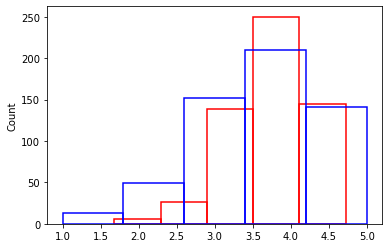

In [55]:
sns.histplot((list(flatten(pred))), bins=5, color='red', fill=False,
#             stat='density', common_norm=False
            )


sns.histplot(ratings[ratings.user==test_user].rating_score.values, bins=5, color='blue', fill=False,
#             stat='density', common_norm=False
            )

plt.show()

In [57]:
test_user_id = ratings[ratings.user==test_user].user_id.unique()[0]
test_user_id

97031706

In [58]:
movie_id_array = ratings[ratings.user_id==test_user_id].movie_id.values.astype(int)
user_id_array = np.array([int(test_user_id) for n in range(len(movie_id_array))])
pred = model.predict([movie_id_array, user_id_array])
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==test_user_id].rating_score.values)

sum(val) / len(pred.flatten())

InvalidArgumentError:  indices[0,0] = 97031704 is not in [0, 64816)
	 [[node model/embedding_1/embedding_lookup (defined at <ipython-input-13-0362bc84e463>:6) ]] [Op:__inference_predict_function_492]

Errors may have originated from an input operation.
Input Source operations connected to node model/embedding_1/embedding_lookup:
 model/embedding_1/embedding_lookup/442 (defined at /home/sahar/anaconda3/envs/tf_env/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function


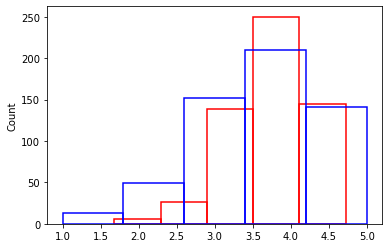

In [55]:
sns.histplot((list(flatten(pred))), bins=5, color='red', fill=False,
#             stat='density', common_norm=False
            )


sns.histplot(ratings[ratings.user==test_user].rating_score.values, bins=5, color='blue', fill=False,
#             stat='density', common_norm=False
            )

plt.show()

### Check X_test

In [9]:
X_test.head()

,movie,user,rating_score
14516575,488,20665,4
710117,1561,47335,3
1264453,1776,6414,4
12875819,187,63513,3
3378686,3293,50692,3


In [44]:
X_test.shape

(2656228, 3)

In [25]:
random_10000_users = random.choices(X_test.user.unique(), k=10000)

In [26]:
predictions = []
accuracy = []

for user in random_10000_users:
    movie_array = X_test[X_test.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), X_test[X_test.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    accuracy.append(sum(val) / len(pred.flatten()))

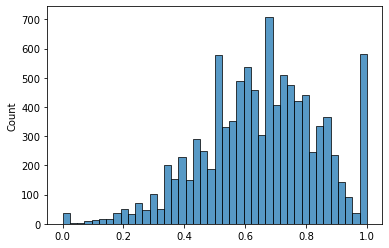

In [27]:
sns.histplot(accuracy)
plt.show()

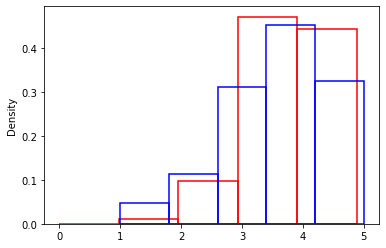

In [28]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False,
            stat='density', common_norm=False)


sns.histplot(X_test[X_test.user.isin(random_10000_users)].rating_score.values, bins=5, color='blue', fill=False,
            stat='density', common_norm=False)

plt.show()

In [32]:
X_test.groupby('user').count()['movie'].loc[random_10000_users].values

array([ 50, 176,  38, ...,  22,   9,  11])

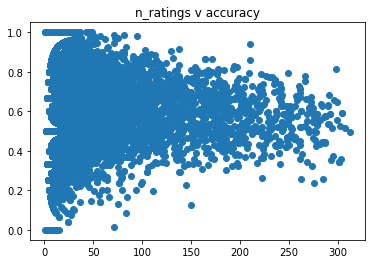

In [37]:
plt.scatter(x=X_test.groupby('user').count()['movie'].loc[random_10000_users].values,
           y=accuracy)

plt.title('n_ratings v accuracy')
plt.show()

In [36]:
X_test.groupby('user').mean()['rating_score'].loc[random_10000_users].values

array([3.2       , 2.65909091, 3.73684211, ..., 4.81818182, 4.66666667,
       2.        ])

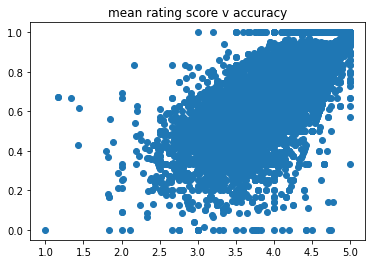

In [38]:
plt.scatter(x=X_test.groupby('user').mean()['rating_score'].loc[random_10000_users].values,
           y=accuracy)

plt.title('mean rating score v accuracy')
plt.show()

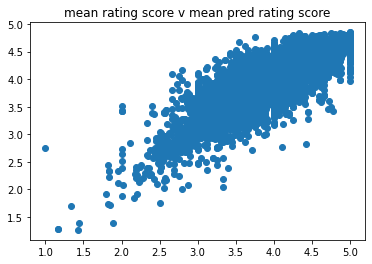

In [42]:
plt.scatter(x=X_test.groupby('user').mean()['rating_score'].loc[random_10000_users].values,
           y=[np.mean(pred) for pred in predictions])

plt.title('mean rating score v mean pred rating score')
plt.show()

Generate suggestions

In [74]:
unique_movies = ratings.movie.unique().astype(int)

In [75]:
suggestions = {}
for user in random_10000_users: 
    user_array = np.ones(shape=len(unique_movies), dtype=int) * int(user)
    preds = model.predict([unique_movies, user_array])    
    suggestions[user] = preds
    del preds
    

KeyboardInterrupt: 

In [82]:
suggestions.keys()

dict_keys([53414, 51243, 38557, 15582, 4706, 59224, 14287, 49087, 32441, 62958, 43646, 39753, 23463, 61849, 54735, 53494, 34789, 24150, 45246, 38142, 27732, 45145, 15637, 11813, 54993, 56904, 33627, 26411, 61421, 51833, 9109, 62995, 38499, 50417, 7049, 3769, 23156, 4329, 52887, 38379, 23036, 43693, 27500, 60201, 11549, 47171, 56020, 3586, 51786, 19135, 11908, 57502, 1247, 14535, 26735, 31109, 16115, 38857, 5071, 8279, 35120, 55860, 56161, 11132, 22858, 19702, 6334, 48810, 38133, 50389, 13858, 32069, 46828, 51896, 49611, 1322, 34955, 52109, 20449, 57651, 3670, 32033, 35547, 4389, 12392, 17512, 18779, 9150, 34325, 36122, 1290, 1805, 20738, 25246, 5104, 29267, 5250, 25075, 51246, 55197, 15091, 5925, 55736, 17198, 1612, 35355, 19066, 59323, 19421, 14596, 10767, 59255, 16906, 28744, 43052, 2376, 29778, 17116, 5958, 62476, 54378, 5651, 18109, 29494, 49896, 16659, 48691, 41031, 48614, 34416, 57985, 36916, 192, 11796, 11345, 53935, 39628, 43686, 27017, 58258, 1769, 26621, 51876, 48703, 31489, 

In [85]:
len(unique_movies)

89418

In [84]:
suggestions[53414].shape

(89418, 1)

In [137]:
def get_recs(user):
    has_seen = [np.where(unique_movies==r)[0][0] for r in ratings[ratings.user==user].movie]
    
    movies_to_eval = random.choices(range(len(unique_movies)), k=100)
    movies_to_eval = [m for m in movies_to_eval if m not in list(has_seen)]

    if len(movies_to_eval) != 100:
        print(len(movies_to_eval))
        still_need = 100 - len(movies_to_eval)
        extras = random.choices(range(len(unique_movies)), k=still_need)
        for e in extras:
            if (e not in movies_to_eval) and (e not in has_seen):
                movies_to_eval.append(e)
            else:
                continue
                
    movies_ratings = list(zip(unique_movies[movies_to_eval], suggestions[user].flatten()[movies_to_eval]))
    movies_ratings.sort(key=lambda x: x[1], reverse=True)
    
    return movies_ratings[:5]

In [138]:
get_recs(62958)

[(12862, 4.8761406),
 (88809, 4.8732953),
 (7204, 4.859052),
 (5125, 4.857744),
 (1430, 4.856882)]

In [139]:
def get_user_model_performance(user):
    has_seen = [np.where(unique_movies==r)[0][0] for r in ratings[ratings.user==user].movie]
    
    user_pred = suggestions[user].flatten()[has_seen]
    user_ratings = ratings[(ratings.user==user)&ratings.movie.isin(unique_movies[has_seen])].rating_score.values
    vals = is_close_enough(user_pred, user_ratings)
    
    return sum(vals) / len(user_pred)

In [140]:
get_user_model_performance(62958)

1.0

In [141]:
def get_user_n_reviews(user):
    return len(ratings[ratings.user==user].movie)

In [145]:
get_user_n_reviews(10110)

30

In [149]:
def get_user_top_n_movies(user, n=10):
    ranks = ratings[ratings.user==user].sort_values(by='rating_score', ascending=False)
    
    return ranks[['movie', 'rating_score']][:n]

In [150]:
get_user_top_n_movies(10110)

,movie,rating_score
524612,1487,5
897364,1628,5
14494126,486,5
14234365,433,5
14229449,432,5
14223621,431,5
14219063,430,5
14062082,388,5
13736669,306,5
13643382,299,5


In [100]:
has_seen = [np.where(unique_movies==r)[0][0] for r in ratings[ratings.user==53414].movie]

In [107]:
movies_to_eval = random.choices(range(len(unique_movies)), k=100)
movies_to_eval = [m for m in movies_to_eval if m not in list(has_seen)]

if len(movies_to_eval) != 100:
    print(len(movies_to_eval))
    still_need = 100 - len(movies_to_eval)
    extras = random.choices(range(len(unique_movies)), k=still_need)
    for e in extras:
        if (e not in movies_to_eval) and (e not in has_seen):
            movies_to_eval.append(e)
        else:
            continue

In [114]:
movies_ratings = list(zip(unique_movies[movies_to_eval], suggestions[53414].flatten()[movies_to_eval]))

In [119]:
movies_ratings.sort(key=lambda x: x[1], reverse=True)

In [121]:
movies_ratings[:5]

[(44977, 4.7330565),
 (62068, 4.4069037),
 (26668, 4.3716874),
 (23919, 4.3637886),
 (14437, 4.281595)]

In [127]:
len(ratings[(ratings.user==53414)&ratings.movie.isin(unique_movies[has_seen])].rating_score.values)

161

In [126]:
len(suggestions[53414].flatten()[has_seen])

161

In [128]:
user_pred = suggestions[53414].flatten()[has_seen]
user_ratings = ratings[(ratings.user==53414)&ratings.movie.isin(unique_movies[has_seen])].rating_score.values
vals = is_close_enough(user_pred, user_ratings)

In [129]:
sum(vals) / len(user_pred)

0.40993788819875776

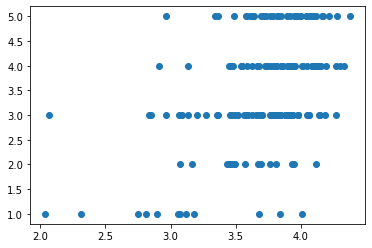

In [130]:
plt.scatter(user_pred, user_ratings)

plt.show()

In [134]:
user_accuracy = list(zip(random_10000_users, accuracy))

In [135]:
user_accuracy.sort(key=lambda x: x[1], reverse=True)

In [153]:
goods = random.choices([user_pair for user_pair in user_accuracy if (user_pair[1] < 1) and (user_pair[1] >= .8)], k=100)

In [154]:
for pairs in goods:
    n_reviews = get_user_n_reviews(pairs[0])
    print(pairs, n_reviews)

(57933, 0.9333333333333333) 52
(40090, 0.9090909090909091) 46
(27750, 0.8) 25
(58633, 0.8333333333333334) 21
(55753, 0.8333333333333334) 29
(21767, 0.8181818181818182) 23
(7951, 0.8) 25
(48038, 0.8333333333333334) 37
(26687, 0.8) 60
(23894, 0.8181818181818182) 74
(6256, 0.8571428571428571) 203
(4030, 0.8) 32
(62250, 0.8392857142857143) 208
(19244, 0.8823529411764706) 63
(18248, 0.8) 38
(38763, 0.9285714285714286) 96
(34053, 0.8888888888888888) 30
(1789, 0.8045112781954887) 477
(24458, 0.8387096774193549) 90
(31758, 0.84) 68
(1247, 0.8571428571428571) 23
(7425, 0.8235294117647058) 54
(48226, 0.8) 35
(15392, 0.9) 25
(63105, 0.8085106382978723) 173
(57160, 0.8333333333333334) 21
(17513, 0.8) 72
(54545, 0.8888888888888888) 37
(41163, 0.8043478260869565) 138
(64503, 0.8095238095238095) 69
(22032, 0.8666666666666667) 64
(51062, 0.8) 33
(32258, 0.8181818181818182) 26
(10203, 0.8571428571428571) 29
(64368, 0.9230769230769231) 92
(52918, 0.8928571428571429) 102
(23819, 0.8888888888888888) 30
(6

In [151]:
user_accuracy[500:550]

[(33237, 1.0),
 (57226, 1.0),
 (43445, 1.0),
 (17622, 1.0),
 (6300, 1.0),
 (39443, 1.0),
 (11675, 1.0),
 (30834, 1.0),
 (35500, 1.0),
 (33002, 1.0),
 (26712, 1.0),
 (7245, 1.0),
 (61378, 1.0),
 (59097, 1.0),
 (33870, 1.0),
 (33115, 1.0),
 (24795, 1.0),
 (19851, 1.0),
 (918, 1.0),
 (39079, 1.0),
 (41812, 1.0),
 (2178, 1.0),
 (12633, 1.0),
 (10173, 1.0),
 (46007, 1.0),
 (39796, 1.0),
 (24807, 1.0),
 (43042, 1.0),
 (45467, 1.0),
 (11616, 1.0),
 (15052, 1.0),
 (18535, 1.0),
 (9538, 1.0),
 (12668, 1.0),
 (38752, 1.0),
 (60708, 1.0),
 (14179, 1.0),
 (30717, 1.0),
 (54975, 1.0),
 (26810, 1.0),
 (41968, 1.0),
 (33554, 1.0),
 (13037, 1.0),
 (57176, 1.0),
 (55751, 1.0),
 (13737, 1.0),
 (59529, 1.0),
 (32289, 1.0),
 (61253, 1.0),
 (55374, 1.0)]

In [146]:
for pairs in user_accuracy[:200]:
    n_reviews = get_user_n_reviews(pairs[0])
    print(pairs, n_reviews)

(62958, 1.0) 146
(38499, 1.0) 34
(7049, 1.0) 21
(19135, 1.0) 26
(35120, 1.0) 23
(19702, 1.0) 21
(4389, 1.0) 22
(5651, 1.0) 44
(12510, 1.0) 42
(24688, 1.0) 73
(16250, 1.0) 24
(47917, 1.0) 24
(64048, 1.0) 31
(32712, 1.0) 25
(42092, 1.0) 57
(30449, 1.0) 76
(21232, 1.0) 28
(18420, 1.0) 30
(47286, 1.0) 26
(37262, 1.0) 30
(24067, 1.0) 20
(57049, 1.0) 29
(21066, 1.0) 30
(33428, 1.0) 44
(57442, 1.0) 20
(60220, 1.0) 20
(3289, 1.0) 21
(54901, 1.0) 24
(24807, 1.0) 91
(61988, 1.0) 31
(58765, 1.0) 29
(4705, 1.0) 25
(34129, 1.0) 20
(28240, 1.0) 25
(55030, 1.0) 36
(40456, 1.0) 30
(1264, 1.0) 39
(44033, 1.0) 126
(25857, 1.0) 27
(29334, 1.0) 41
(33738, 1.0) 26
(17373, 1.0) 69
(7182, 1.0) 20
(45201, 1.0) 24
(39103, 1.0) 34
(59419, 1.0) 33
(31767, 1.0) 24
(21988, 1.0) 25
(18976, 1.0) 22
(52432, 1.0) 20
(17029, 1.0) 22
(21220, 1.0) 20
(53055, 1.0) 35
(57486, 1.0) 28
(45347, 1.0) 47
(12382, 1.0) 30
(38175, 1.0) 29
(46407, 1.0) 25
(35297, 1.0) 27
(31272, 1.0) 26
(62620, 1.0) 28
(37187, 1.0) 31
(28383, 1.0) 